# Import Libraries

In [55]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
import datetime

from tqdm import tqdm
from fbprophet import Prophet

import lightgbm as lgb

In [2]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro Bronx',
        'Triboro Manhattan',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [3]:
df = return_series('mta.csv')

In [23]:
_df = df.unstack().T

In [24]:
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [25]:
_df = _df.reset_index()
_df

plaza_id,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
0,2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286
1,2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211
2,2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974
3,2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114
4,2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229
...,...,...,...,...,...,...,...,...,...,...,...
981,2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270
982,2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513
983,2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546
984,2020-09-11,56878,24493,70659,24483,73386,111209,139712,39046,107214,131970


In [26]:
_df.columns

Index(['datetime', 'Brooklyn Battery', 'Cross Bay', 'Henry Hudson',
       'Marine Parkway', 'Queens Midtown', 'Throgs Neck', 'Triboro Bronx',
       'Triboro Manhattan', 'Verrazano', 'Whitestone'],
      dtype='object', name='plaza_id')

In [36]:
_df_melt = pd.melt(_df, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro Bronx',
                                                        'Triboro Manhattan', 'Verrazano', 'Whitestone'])
_df_melt.set_index('datetime', inplace=True)
_df_melt

,plaza_id,value
datetime,,
2018-01-01,Brooklyn Battery,29163
2018-01-02,Brooklyn Battery,47160
2018-01-03,Brooklyn Battery,54005
2018-01-04,Brooklyn Battery,20484
2018-01-05,Brooklyn Battery,38007
...,...,...
2020-09-08,Whitestone,121270
2020-09-09,Whitestone,118513
2020-09-10,Whitestone,114546


In [37]:

def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter


    conditions = [
        (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4
    ]

    _df['Phase'] = np.select(conditions, choices, 5)
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    
    return _df

In [38]:
_df_melt = date_features(_df_melt)
_df_melt.reset_index(inplace=True)

In [39]:
conditions = [
    _df_melt['plaza_id'].eq('Triboro Bronx'),
    _df_melt['plaza_id'].eq('Triboro Manhattan'),
    _df_melt['plaza_id'].eq('Whitestone'),
    _df_melt['plaza_id'].eq('Henry Hudson'),
    _df_melt['plaza_id'].eq('Marine Parkway'),
    _df_melt['plaza_id'].eq('Cross Bay'),
    _df_melt['plaza_id'].eq('Quessn Midtown'),
    _df_melt['plaza_id'].eq('Brooklyn Battery'),
    _df_melt['plaza_id'].eq('Throgs Neck'),
    _df_melt['plaza_id'].eq('Verrazano')
    
]
choices = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10
]

_df_melt['plaza_id'] = np.select(conditions, choices, 0)
_df_melt

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,121270,9,1,2020,37,8,3,4,0
9856,2020-09-09,3,118513,9,2,2020,37,9,3,4,0
9857,2020-09-10,3,114546,9,3,2020,37,10,3,4,0
9858,2020-09-11,3,131970,9,4,2020,37,11,3,4,0


In [47]:
train_set = _df_melt.loc[_df_melt['datetime'] <= '2020-08-22'].copy()
test_set = _df_melt.loc[_df_melt['datetime'] > '2020-08-22'].copy()
# test_set

In [48]:
# train_set

In [49]:
train_set['lag_7'] = train_set[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
train_set['lag_28'] = train_set[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
train_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,NaN,NaN
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,NaN,NaN
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,NaN,NaN
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,NaN,NaN
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2020-08-18,3,123407,8,1,2020,34,18,3,4,0,123273.0,114042.0
9835,2020-08-19,3,122248,8,2,2020,34,19,3,4,0,116497.0,112825.0
9836,2020-08-20,3,136581,8,3,2020,34,20,3,4,0,122549.0,115346.0
9837,2020-08-21,3,146062,8,4,2020,34,21,3,4,0,141229.0,127859.0


In [61]:
train_set['mean_lag7_roll7'] = train_set[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(7).mean())
train_set['mean_lag7_roll28'] = train_set[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(28).mean())
train_set['mean_lag28_roll7'] = train_set[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(7).mean())
train_set['mean_lag28_roll28'] = train_set[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(28).mean())
train_set['week'] = train_set['week'].astype('int64')

In [62]:
categorical_features = ['plaza_id', 'month', 'dayofweek', 'year', 'week', 'day', 'Phase']
useless_cols = ['datetime', 'value']
train_cols = train_set.columns[~train_set.columns.isin(useless_cols)]
X_train = train_set[train_cols]
y_train = train_set['value']

In [63]:

train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
fake_valid_inds = np.random.choice(len(X_train), 2000)
fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=categorical_features,
                             free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !

In [64]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
#     'num_iterations' : 200,
    'num_iterations' : 2500,
}

In [65]:
m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=100)

[100]	valid_0's rmse: 7897.6
[200]	valid_0's rmse: 4626.09
[300]	valid_0's rmse: 3457.95
[400]	valid_0's rmse: 2993.37
[500]	valid_0's rmse: 2709.57
[600]	valid_0's rmse: 2463.29
[700]	valid_0's rmse: 2273.83
[800]	valid_0's rmse: 2124.25
[900]	valid_0's rmse: 1986.74
[1000]	valid_0's rmse: 1868.24
[1100]	valid_0's rmse: 1764.15
[1200]	valid_0's rmse: 1671.86
[1300]	valid_0's rmse: 1575.69
[1400]	valid_0's rmse: 1488.91
[1500]	valid_0's rmse: 1412.24
[1600]	valid_0's rmse: 1340.61
[1700]	valid_0's rmse: 1274.3
[1800]	valid_0's rmse: 1210.55
[1900]	valid_0's rmse: 1151.1
[2000]	valid_0's rmse: 1096.62
[2100]	valid_0's rmse: 1046.46
[2200]	valid_0's rmse: 999.591
[2300]	valid_0's rmse: 956.301
[2400]	valid_0's rmse: 915.307
[2500]	valid_0's rmse: 874.928


In [80]:
first_iter = test_set.loc[test_set['datetime'] <= '2020-08-29'].copy()
first_iter['value'] = np.nan
first_iter

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend
965,2020-08-23,8,NaN,8,6,2020,34,23,3,4,1
966,2020-08-24,8,NaN,8,0,2020,35,24,3,4,0
967,2020-08-25,8,NaN,8,1,2020,35,25,3,4,0
968,2020-08-26,8,NaN,8,2,2020,35,26,3,4,0
969,2020-08-27,8,NaN,8,3,2020,35,27,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0


In [81]:
train_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2020-08-18,3,123407,8,1,2020,34,18,3,4,0,123273.0,114042.0,126017.571429,119920.464286,115296.571429,110016.607143
9835,2020-08-19,3,122248,8,2,2020,34,19,3,4,0,116497.0,112825.0,124832.000000,120017.928571,115161.857143,110290.714286
9836,2020-08-20,3,136581,8,3,2020,34,20,3,4,0,122549.0,115346.0,124196.428571,120275.142857,115161.714286,110454.714286
9837,2020-08-21,3,146062,8,4,2020,34,21,3,4,0,141229.0,127859.0,126062.571429,120858.142857,115583.714286,110688.392857


In [82]:
_first_concat = pd.concat([train_set, first_iter])
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,NaN,NaN,NaN,NaN,NaN,NaN
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,NaN,NaN,NaN,NaN,NaN,NaN
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,NaN,NaN,NaN,NaN,NaN,NaN
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
_first_concat['lag_7'] = _first_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)

In [84]:
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,123407.0,NaN,NaN,NaN,NaN,NaN
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,122248.0,NaN,NaN,NaN,NaN,NaN
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,136581.0,NaN,NaN,NaN,NaN,NaN
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,146062.0,NaN,NaN,NaN,NaN,NaN


In [86]:
_first_concat['lag_28'] = _first_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,123407.0,112652.0,NaN,NaN,NaN,NaN
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,122248.0,121317.0,NaN,NaN,NaN,NaN
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,136581.0,123436.0,NaN,NaN,NaN,NaN
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,146062.0,137638.0,NaN,NaN,NaN,NaN


In [87]:
_first_concat['mean_lag7_roll7'] = _first_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(7).mean())
_first_concat['mean_lag7_roll28'] = _first_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(28).mean())
_first_concat['mean_lag28_roll7'] = _first_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(7).mean())
_first_concat['mean_lag28_roll28'] = _first_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(28).mean())
_first_concat['week'] = _first_concat['week'].astype('int64')
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,123407.0,112652.0,123723.857143,122027.285714,119639.428571,113197.250000
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,122248.0,121317.0,124545.428571,122363.821429,120852.571429,113549.821429
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,136581.0,123436.0,126550.000000,123122.214286,122008.285714,113387.892857
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,146062.0,137638.0,127240.428571,123772.321429,123405.285714,114353.035714


In [126]:
_whatami = _first_concat['datetime'] + datetime.timedelta(days=7)
len(_whatami.unique())

972

In [128]:
_whatami

0      2018-01-08
1      2018-01-09
2      2018-01-10
3      2018-01-11
4      2018-01-12
          ...    
9841   2020-09-01
9842   2020-09-02
9843   2020-09-03
9844   2020-09-04
9845   2020-09-05
Name: datetime, Length: 9720, dtype: datetime64[ns]

In [130]:
train_set.loc[train_set['datetime'].isin(_whatami)]

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
7,2018-01-08,8,50087,1,0,2018,2,8,1,5,0,29163.0,NaN,NaN,NaN,NaN,NaN
8,2018-01-09,8,53579,1,1,2018,2,9,1,5,0,47160.0,NaN,NaN,NaN,NaN,NaN
9,2018-01-10,8,53635,1,2,2018,2,10,1,5,0,54005.0,NaN,NaN,NaN,NaN,NaN
10,2018-01-11,8,56897,1,3,2018,2,11,1,5,0,20484.0,NaN,NaN,NaN,NaN,NaN
11,2018-01-12,8,56173,1,4,2018,2,12,1,5,0,38007.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2020-08-18,3,123407,8,1,2020,34,18,3,4,0,123273.0,114042.0,126017.571429,119920.464286,115296.571429,110016.607143
9835,2020-08-19,3,122248,8,2,2020,34,19,3,4,0,116497.0,112825.0,124832.000000,120017.928571,115161.857143,110290.714286
9836,2020-08-20,3,136581,8,3,2020,34,20,3,4,0,122549.0,115346.0,124196.428571,120275.142857,115161.714286,110454.714286
9837,2020-08-21,3,146062,8,4,2020,34,21,3,4,0,141229.0,127859.0,126062.571429,120858.142857,115583.714286,110688.392857


In [127]:
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28,first_pred
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,32375.743503
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,46656.767909
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,52176.886078
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,17256.123529
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,36700.670431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,123407.0,112652.0,123723.857143,122027.285714,119639.428571,113197.250000,123491.173784
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,122248.0,121317.0,124545.428571,122363.821429,120852.571429,113549.821429,122851.281792
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,136581.0,123436.0,126550.000000,123122.214286,122008.285714,113387.892857,136673.495820
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,146062.0,137638.0,127240.428571,123772.321429,123405.285714,114353.035714,143335.453295


In [122]:
_first_concat.loc[_first_concat['datetime'] >= '2020-08-23']

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28,first_pred
965,2020-08-23,8,NaN,8,6,2020,34,23,3,4,1,26879.0,29490.0,46940.571429,45989.250000,44800.000000,42905.964286,32002.883467
966,2020-08-24,8,NaN,8,0,2020,35,24,3,4,0,51279.0,50115.0,46819.285714,46092.285714,45045.857143,42902.821429,49178.069580
967,2020-08-25,8,NaN,8,1,2020,35,25,3,4,0,54168.0,52367.0,47015.285714,46256.464286,45445.285714,42989.714286,51908.857262
968,2020-08-26,8,NaN,8,2,2020,35,26,3,4,0,52481.0,52472.0,46905.857143,46228.428571,45331.857143,42990.178571,52378.278657
969,2020-08-27,8,NaN,8,3,2020,35,27,3,4,0,57221.0,50005.0,47181.000000,46404.142857,45003.857143,42788.500000,57491.062486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,123407.0,112652.0,123723.857143,122027.285714,119639.428571,113197.250000,123491.173784
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,122248.0,121317.0,124545.428571,122363.821429,120852.571429,113549.821429,122851.281792
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,136581.0,123436.0,126550.000000,123122.214286,122008.285714,113387.892857,136673.495820
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,146062.0,137638.0,127240.428571,123772.321429,123405.285714,114353.035714,143335.453295


In [88]:
_first_concat_feats = _first_concat[train_cols]
_first_concat_feats

,plaza_id,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,8,1,0,2018,1,1,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1,1,2018,1,2,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1,2,2018,1,3,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
3,8,1,3,2018,1,4,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1,4,2018,1,5,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,3,8,1,2020,35,25,3,4,0,123407.0,112652.0,123723.857143,122027.285714,119639.428571,113197.250000
9842,3,8,2,2020,35,26,3,4,0,122248.0,121317.0,124545.428571,122363.821429,120852.571429,113549.821429
9843,3,8,3,2020,35,27,3,4,0,136581.0,123436.0,126550.000000,123122.214286,122008.285714,113387.892857
9844,3,8,4,2020,35,28,3,4,0,146062.0,137638.0,127240.428571,123772.321429,123405.285714,114353.035714


In [89]:
first_pred = m_lgb.predict(_first_concat_feats)

In [94]:
len(first_pred)

9720

In [97]:
first_pred

array([ 32375.74350258,  46656.7679088 ,  52176.88607781, ...,
       136673.49581967, 143335.45329454, 135860.09271269])

In [99]:
_first_concat['first_pred'] = first_pred

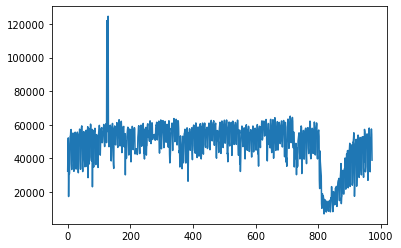

In [103]:
_first_concat.loc[_first_concat['plaza_id'].eq(8)]['first_pred'].plot()

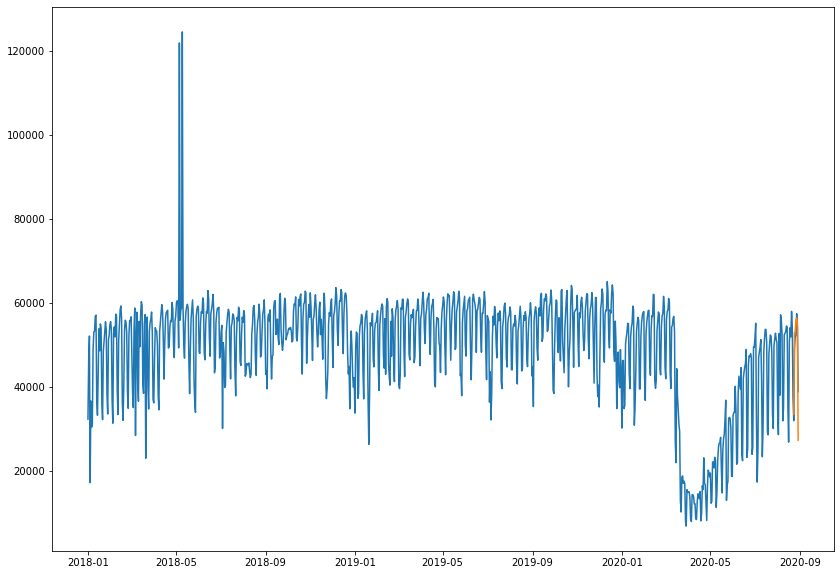

In [111]:
plt.figure(figsize=(14,10))
plt.plot(pd.date_range(start='2018-01-01', end = '2020-08-29'), _first_concat.loc[_first_concat['plaza_id'].eq(8)]['first_pred'])
plt.plot(pd.date_range(start='2020-08-23', end = '2020-08-29'), test_set.loc[(test_set['datetime'] <= '2020-08-29') & test_set['plaza_id'].eq(8)]['value'])

In [108]:
test_set.loc[(test_set['datetime'] <= '2020-08-29') & test_set['plaza_id'].eq(8)]

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend
965,2020-08-23,8,33512,8,6,2020,34,23,3,4,1
966,2020-08-24,8,52900,8,0,2020,35,24,3,4,0
967,2020-08-25,8,53262,8,1,2020,35,25,3,4,0
968,2020-08-26,8,56023,8,2,2020,35,26,3,4,0
969,2020-08-27,8,56449,8,3,2020,35,27,3,4,0
970,2020-08-28,8,55428,8,4,2020,35,28,3,4,0
971,2020-08-29,8,27376,8,5,2020,35,29,3,4,1


In [113]:
_first_concat.loc[_first_concat['plaza_id'].eq(8)]['first_pred'][-7:]

965    32002.883467
966    49178.069580
967    51908.857262
968    52378.278657
969    57491.062486
970    54432.182148
971    38898.542160
Name: first_pred, dtype: float64

In [114]:
np.sqrt(mean_squared_error(_first_concat.loc[_first_concat['plaza_id'].eq(8)]['first_pred'][-7:], 
                           test_set.loc[(test_set['datetime'] <= '2020-08-29') & test_set['plaza_id'].eq(8)]['value']))

4871.076632809832

In [120]:
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28,first_pred
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,32375.743503
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,46656.767909
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,52176.886078
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,17256.123529
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN,36700.670431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,123407.0,112652.0,123723.857143,122027.285714,119639.428571,113197.250000,123491.173784
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,122248.0,121317.0,124545.428571,122363.821429,120852.571429,113549.821429,122851.281792
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,136581.0,123436.0,126550.000000,123122.214286,122008.285714,113387.892857,136673.495820
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,146062.0,137638.0,127240.428571,123772.321429,123405.285714,114353.035714,143335.453295


In [32]:

def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter


    conditions = [
        (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    
    return _df

In [33]:
_df = date_features(_df)
_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone,month,dayofweek,year,week,day,quarter,Phase,weekend
datetime,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286,1,0,2018,1,1,1,-1,0
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211,1,1,2018,1,2,1,-1,0
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974,1,2,2018,1,3,1,-1,0
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114,1,3,2018,1,4,1,-1,0
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229,1,4,2018,1,5,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270,9,1,2020,37,8,3,4,0
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513,9,2,2020,37,9,3,4,0
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546,9,3,2020,37,10,3,4,0


In [34]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek', 'quarter', 'Phase']
_df_ohe = ohe.fit_transform(_df[categorical_columns]).toarray()
_df_ohe_df = pd.DataFrame(data = _df_ohe,
                           index = _df.index,
                          columns = ohe.get_feature_names(categorical_columns))

_df_merged = _df.merge(_df_ohe_df, left_index=True, right_index=True)
# _df_merged

,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone,...,dayofweek_5,dayofweek_6,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
_df_ohe_df['weekend'] = _df['weekend']

In [36]:
tr_start,tr_end = '2018-01-01','2020-08-20'
te_start,te_end = '2020-08-21','2020-09-12'
tra = _df_merged[tr_start:tr_end]['Brooklyn Battery'].dropna()
tes = _df_merged[te_start:te_end]['Brooklyn Battery'].dropna()
exog_train = _df_ohe_df[tr_start:tr_end]
exog_test = _df_ohe_df[te_start:te_end]

In [46]:
pred_far = pd.DataFrame()
pred_far['date'] = pd.date_range(start='2020-08-21',end='2020-12-31')
pred_far.set_index('date', inplace=True)
pred_far = date_features(pred_far)
_far_ohe = ohe.transform(pred_far[categorical_columns]).toarray()
_far_ohe_df = pd.DataFrame(data = _far_ohe,
                          index = pred_far.index,
                          columns = ohe.get_feature_names(categorical_columns))
_far_ohe_df['weekend'] = pred_far['weekend']


In [65]:
def return_arima_rmse(bridge):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-08-20'
    te_start,te_end = '2020-08-21','2020-09-12'
    tra = _df_merged[tr_start:tr_end][bridge].dropna()
    tes = _df_merged[te_start:te_end][bridge].dropna()
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    
    model_SARIMAX = SARIMAX(tra,order=(7,0,7),seasonal_order=(1,0,0,12), exog = exog_train,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
    results = model_SARIMAX.fit()
    
    pred = results.predict(te_start,te_end, exog = exog_test)
    return np.sqrt(mean_squared_error(tes,pred))

In [66]:
bridges = ['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Queens Midtown', 'Throgs Neck', 'Triboro Bronx', 'Triboro Manhattan',
       'Verrazano', 'Whitestone']

l1 = []
for i in tqdm(bridges):
    l1.append(return_arima_rmse(i))

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 10%|█         | 1/10 [00:46<06:54, 46.06s/it]C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 20%|██        | 2/10 [01:38<06:24, 48.12s/it]C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 30%|███       | 3/10 [02:20<05:22, 46.02s/it]C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceW

In [64]:
_arimax_707 = pd.DataFrame()
_arimax_707['bridges'] = bridges
_arimax_707['ARIMAX_707'] = l1
_arimax_707

,bridges,ARIMAX_707
0,Brooklyn Battery,5074.906009
1,Cross Bay,2896.753200
2,Henry Hudson,4392.307992
3,Marine Parkway,4723.397467
4,Queens Midtown,5106.611011
5,Throgs Neck,8280.711846
6,Triboro Bronx,6512.923057
7,Triboro Manhattan,2518.803089
8,Verrazano,5071.075134
9,Whitestone,7367.182183


In [67]:
_arimax_707['SARIMAX_707'] = l1
_arimax_707

,bridges,ARIMAX_707,SARIMAX_707
0,Brooklyn Battery,5074.906009,5033.227333
1,Cross Bay,2896.753200,2875.775714
2,Henry Hudson,4392.307992,4518.836266
3,Marine Parkway,4723.397467,4757.148215
4,Queens Midtown,5106.611011,5139.652622
5,Throgs Neck,8280.711846,8294.155380
6,Triboro Bronx,6512.923057,6518.488501
7,Triboro Manhattan,2518.803089,2507.930127
8,Verrazano,5071.075134,5166.545028
9,Whitestone,7367.182183,7526.185880


In [71]:
lockdown = pd.DataFrame({
  'holiday': 'lockdown',
  'ds': pd.date_range(start='2020-03-21', end='2020-06-07'),
  'lower_window': 0,
  'upper_window': 1,
})
phase_1 = pd.DataFrame({
  'holiday': 'Phase_1',
  'ds': pd.date_range(start='2020-06-08', end='2020-06-21'),
  'lower_window': 0,
  'upper_window': 1,
})
phase_2 = pd.DataFrame({
  'holiday': 'Phase_2',
  'ds': pd.date_range(start='2020-06-22', end='2020-07-05'),
  'lower_window': 0,
  'upper_window': 1,
})
phase_3 = pd.DataFrame({
  'holiday': 'Phase_3',
  'ds': pd.date_range(start='2020-07-06', end='2020-07-18'),
  'lower_window': 0,
  'upper_window': 1,
})
phase_4 = pd.DataFrame({
  'holiday': 'Phase_4',
  'ds': pd.date_range(start='2020-07-19', end='2020-12-31'),
  'lower_window': 0,
  'upper_window': 1,
})


holidays = pd.concat((lockdown, phase_1, phase_2, phase_3, phase_4))
holidays

,holiday,ds,lower_window,upper_window
0,lockdown,2020-03-21,0,1
1,lockdown,2020-03-22,0,1
2,lockdown,2020-03-23,0,1
3,lockdown,2020-03-24,0,1
4,lockdown,2020-03-25,0,1
...,...,...,...,...
161,Phase_4,2020-12-27,0,1
162,Phase_4,2020-12-28,0,1
163,Phase_4,2020-12-29,0,1
164,Phase_4,2020-12-30,0,1


In [72]:
tr_start,tr_end = '2018-01-01','2020-08-20'
te_start,te_end = '2020-08-21','2020-09-12'
tra = _df_merged[tr_start:tr_end]['Brooklyn Battery'].dropna()
tes = _df_merged[te_start:te_end]['Brooklyn Battery'].dropna()
exog_train = _df_ohe_df[tr_start:tr_end]
exog_test = _df_ohe_df[te_start:te_end]

In [73]:
m = Prophet(holidays=holidays,
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(tra)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [78]:
tra = tra.reset_index()
tra.columns = ['ds', 'y']

In [79]:
m.fit(tra)

In [85]:
future = m.make_future_dataframe(periods=23)
future

,ds
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
981,2020-09-08
982,2020-09-09
983,2020-09-10
984,2020-09-11


In [92]:
future = pd.DataFrame(data= pd.date_range(start= '2020-08-21', end = '2020-09-12'), columns =['ds'])

In [93]:
future

,ds
0,2020-08-21
1,2020-08-22
2,2020-08-23
3,2020-08-24
4,2020-08-25
5,2020-08-26
6,2020-08-27
7,2020-08-28
8,2020-08-29
9,2020-08-30


In [91]:
tes

datetime
2020-08-21    53822
2020-08-22    36817
2020-08-23    33512
2020-08-24    52900
2020-08-25    53262
2020-08-26    56023
2020-08-27    56449
2020-08-28    55428
2020-08-29    27376
2020-08-30    40607
2020-08-31    53652
2020-09-01    54205
2020-09-02    53388
2020-09-03    58136
2020-09-04    56280
2020-09-05    36971
2020-09-06    36329
2020-09-07    31281
2020-09-08    55105
2020-09-09    56553
2020-09-10    55672
2020-09-11    56878
2020-09-12    39373
Freq: D, Name: Brooklyn Battery, dtype: int64

In [100]:
m.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Phase_1,Phase_1_lower,Phase_1_upper,Phase_2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-08-21,38101.702726,36588.195425,63415.040858,38097.297079,38102.723597,0.0,0.0,0.0,0.0,...,4297.082097,4297.082097,4297.082097,3288.107247,3288.107247,3288.107247,0.0,0.0,0.0,49699.063622
1,2020-08-22,38098.110942,23942.147153,50726.111461,38076.400539,38113.597400,0.0,0.0,0.0,0.0,...,-7594.245154,-7594.245154,-7594.245154,3542.264438,3542.264438,3542.264438,0.0,0.0,0.0,38058.301778
2,2020-08-23,38094.519157,22423.654703,49805.328612,38046.494078,38133.546372,0.0,0.0,0.0,0.0,...,-9662.091834,-9662.091834,-9662.091834,3797.463084,3797.463084,3797.463084,0.0,0.0,0.0,36242.061959
3,2020-08-24,38090.927373,33230.443215,59051.133271,38009.790520,38149.565097,0.0,0.0,0.0,0.0,...,-10.125006,-10.125006,-10.125006,4051.226574,4051.226574,4051.226574,0.0,0.0,0.0,46144.200492
4,2020-08-25,38087.335589,36218.179368,63290.538164,37966.978757,38173.573682,0.0,0.0,0.0,0.0,...,3218.650000,3218.650000,3218.650000,4301.374578,4301.374578,4301.374578,0.0,0.0,0.0,49619.531719
5,2020-08-26,38083.743804,36518.520692,63764.166476,37927.841126,38208.624835,0.0,0.0,0.0,0.0,...,3736.650527,3736.650527,3736.650527,4546.085280,4546.085280,4546.085280,0.0,0.0,0.0,50378.651163
6,2020-08-27,38080.152020,39272.093672,65650.213572,37878.660046,38240.368406,0.0,0.0,0.0,0.0,...,6014.079370,6014.079370,6014.079370,4783.941302,4783.941302,4783.941302,0.0,0.0,0.0,52890.344244
7,2020-08-28,38076.560236,38056.622511,65449.299377,37821.816494,38275.708396,0.0,0.0,0.0,0.0,...,4297.082097,4297.082097,4297.082097,5013.958062,5013.958062,5013.958062,0.0,0.0,0.0,51399.771946
8,2020-08-29,38072.968451,26280.603787,54010.769495,37767.582236,38320.635050,0.0,0.0,0.0,0.0,...,-7594.245154,-7594.245154,-7594.245154,5235.593900,5235.593900,5235.593900,0.0,0.0,0.0,39726.488750
9,2020-08-30,38069.376667,23388.950254,51147.913130,37703.260848,38368.185099,0.0,0.0,0.0,0.0,...,-9662.091834,-9662.091834,-9662.091834,5448.742019,5448.742019,5448.742019,0.0,0.0,0.0,37868.198404


In [ ]:
pred = m.predict()

In [108]:
def return_prophet_rmse(bridge):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-08-20'
    te_start,te_end = '2020-08-21','2020-09-12'
    tra = _df_merged[tr_start:tr_end][bridge].dropna()
    tes = _df_merged[te_start:te_end][bridge].dropna()
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    tra = tra.reset_index()
    tra.columns = ['ds','y']
    tes = tes.reset_index()
    tes.columns = ['ds','y']
    
    
    m = Prophet(holidays=holidays,
           changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
    
    m.fit(tra)
    
    future = pd.DataFrame(data= pd.date_range(start= '2020-08-21', end = '2020-09-12'), columns =['ds'])
    
    
    pred = m.predict(future)
    return np.sqrt(mean_squared_error(tes['y'],pred['yhat']))

In [103]:
bridges

['Brooklyn Battery',
 'Cross Bay',
 'Henry Hudson',
 'Marine Parkway',
 'Queens Midtown',
 'Throgs Neck',
 'Triboro Bronx',
 'Triboro Manhattan',
 'Verrazano',
 'Whitestone']

In [109]:
fb_prophet_1 = []
for i in tqdm(bridges):
    fb_prophet.append(return_prophet_rmse(i))

100%|██████████| 10/10 [05:06<00:00, 30.65s/it]


In [115]:
_arimax_707['fb_prophet_1'] = fb_prophet[-10:]
_arimax_707

,bridges,ARIMAX_707,SARIMAX_707,fb_prophet,fb_prophet_1
0,Brooklyn Battery,5074.906009,5033.227333,5725.572935,7873.282697
1,Cross Bay,2896.753200,2875.775714,4168.910659,3296.678936
2,Henry Hudson,4392.307992,4518.836266,5250.787214,6099.712080
3,Marine Parkway,4723.397467,4757.148215,6379.201240,4610.790834
4,Queens Midtown,5106.611011,5139.652622,8116.112951,6100.500781
5,Throgs Neck,8280.711846,8294.155380,6985.117748,7216.992386
6,Triboro Bronx,6512.923057,6518.488501,6389.050726,6503.175218
7,Triboro Manhattan,2518.803089,2507.930127,3296.679739,4020.971637
8,Verrazano,5071.075134,5166.545028,4754.962910,5035.669121
9,Whitestone,7367.182183,7526.185880,7262.443322,8944.088627


In [123]:
_arimax_707.columns = ['bridges', 'ARIMAX_707', 'SARIMAX_707_10012', 'fb_prophet_001', 'fb_prophet_005']
_arimax_707.to_csv('results.csv', index=False, header=True)

In [117]:
_df_merged

,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone,...,dayofweek_5,dayofweek_6,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [120]:
for i in _df_merged.columns:
    _df_merged[i] = _df_merged[i].astype('float')

In [121]:
# model_VARMAX = sm.tsa.VARMAX(_df_merged[tr_start:tr_end][bridges],
#                              order=(7,7), trend = 'n',exog = exog_train, enforce_stationarity=False, enforce_invertibility=False)
# results = model_VARMAX.fit(maxiter=1000, disp=True)
# results.summary()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



KeyboardInterrupt: 